In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Templates

## 1.1 Create templates of object

In [2]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_120288/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [3]:
dataset = "icbin"
obj_id = 1

In [4]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [5]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [6]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [7]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 1.2. Templates features extraction

In [8]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1  + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

324

In [9]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1  + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

324

In [10]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

1284

In [11]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [12]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 224, 224])


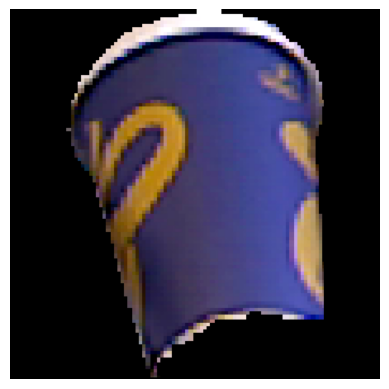

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 224, 224])


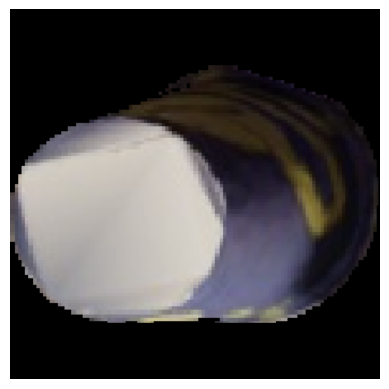

normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 1284 torch.Size([3, 224, 224])


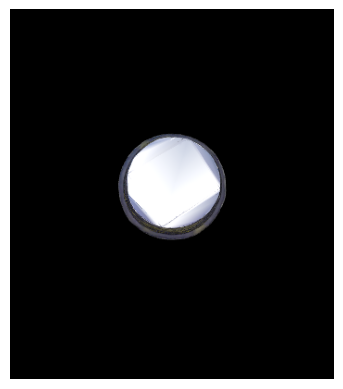

In [13]:
from src.model.custom_cnos import cnos_templates_feature_extraction

real_ref_features = cnos_templates_feature_extraction(
    templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
    )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
pyrender_ref_features = cnos_templates_feature_extraction(
    templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
    )

# 2. Extract proposals for the whole testset of a dataset (here icbin, )

In [14]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

INFO:root:Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything


INFO:root:Init CustomSamAutomaticMaskGenerator done!


In [15]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [16]:
from torch.utils.data import DataLoader
from hydra.utils import instantiate

query_dataloader_config = cfg.data.query_dataloader
cfg.dataset_name = dataset

if cfg.dataset_name in ["hb", "tless"]:
    query_dataloader_config.split = "test_primesense"
else:
    query_dataloader_config.split = "test"
query_dataloader_config.root_dir = "./datasets/bop23_challenge/datasets/" + f"{cfg.dataset_name}" # ./datasets/bop23_challenge/datasets/tless
query_dataset = instantiate(query_dataloader_config) # src.dataloader.bop.BaseBOPTest for tless
# query_dataloader = DataLoader(
#     query_dataset,
#     batch_size=1,  # only support a single image for now
#     num_workers=default_config.machine.num_workers,
#     shuffle=False,
# )

Global seed set to 2023
Global seed set to 2023
INFO:root:Found 3 scenes
INFO:root:Loading metaData for split test
Loading metaData: 100%|██████████| 3/3 [00:00<00:00, 590.55it/s]
INFO:root:Finish loading metaData of size 150 in 0.01 seconds


In [17]:
import torchvision.transforms as T
import numpy as np


inv_rgb_transform = T.Compose(
            [
                T.Normalize(
                    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
                ),
            ]
        )

query_proposals = []
query_images = []
for idx, query in enumerate(query_dataset):
    print("idx", idx)
    image_np = (
        inv_rgb_transform(query["image"])
        .cpu()
        .numpy()
        .transpose(1, 2, 0)
    )
    query_images.append(np.uint8(image_np.clip(0, 1) * 255)) 

idx 0
idx 1
idx 2
idx 3
idx 4
idx 5
idx 6
idx 7
idx 8
idx 9
idx 10
idx 11
idx 12
idx 13
idx 14
idx 15
idx 16
idx 17
idx 18
idx 19
idx 20
idx 21
idx 22
idx 23
idx 24
idx 25
idx 26
idx 27
idx 28
idx 29
idx 30
idx 31
idx 32
idx 33
idx 34
idx 35
idx 36
idx 37
idx 38
idx 39
idx 40
idx 41
idx 42
idx 43
idx 44
idx 45
idx 46
idx 47
idx 48
idx 49
idx 50
idx 51
idx 52
idx 53
idx 54
idx 55
idx 56
idx 57
idx 58
idx 59
idx 60
idx 61
idx 62
idx 63
idx 64
idx 65
idx 66
idx 67
idx 68
idx 69
idx 70
idx 71
idx 72
idx 73
idx 74
idx 75
idx 76
idx 77
idx 78
idx 79
idx 80
idx 81
idx 82
idx 83
idx 84
idx 85
idx 86
idx 87
idx 88
idx 89
idx 90
idx 91
idx 92
idx 93
idx 94
idx 95
idx 96
idx 97
idx 98
idx 99
idx 100
idx 101
idx 102
idx 103
idx 104
idx 105
idx 106
idx 107
idx 108
idx 109
idx 110
idx 111
idx 112
idx 113
idx 114
idx 115
idx 116
idx 117
idx 118
idx 119
idx 120
idx 121
idx 122
idx 123
idx 124
idx 125
idx 126
idx 127
idx 128
idx 129
idx 130
idx 131
idx 132
idx 133
idx 134
idx 135
idx 136
idx 137
idx 13

In [18]:
# # run propoals
# query_proposals = [custom_sam_model.generate_masks(image) for image in query_images]

In [19]:
import torch

# Save the query proposals as torch file 
file_path = 'output_cnos_analysis_5/query_proposals/icbin.pt'
# torch.save(query_proposals, file_path)

In [43]:
# Load the proposals from the file
query_proposals = torch.load(file_path, map_location=torch.device('cpu'))

In [41]:
# # Convert to dict od masks and boxes
# sam_detections = {
#     "masks" : [proposal["masks"] for proposal in query_proposals],
#     "boxes" : [proposal["boxes"] for proposal in query_proposals]
# }

In [46]:
from src.model.utils import BatchedData, Detections, convert_npz_to_json

# init detections with masks and boxes
detections = Detections(query_proposals[0]) # just turn the dict to a class thoi- still keys as masks, boxes

# 3. Final Results

In [22]:
query_proposals
proposals = [np.array(masked_image) for i, masked_image in enumerate(masked_images)]
proposals_features = torch.cat([cnos_crop_feature_extraction(proposal, dinov2_vitl14, device) for proposal in proposals], dim = 0)

NameError: name 'masked_images' is not defined

In [ ]:
from src.model.custom_cnos import custom_detections, custom_visualize

scene_id = 1
image_id = 1
dataset_name = "icbin"
rgb_path = f'datasets/bop23_challenge/datasets/{dataset_name}/test/{scene_id:06d}/rgb/{image_id:06d}.png'

File output_cnos_analysis_5/test.json has been deleted.
File output_cnos_analysis_5/test.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]


Saved predictions to output_cnos_analysis_5/test.json


100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


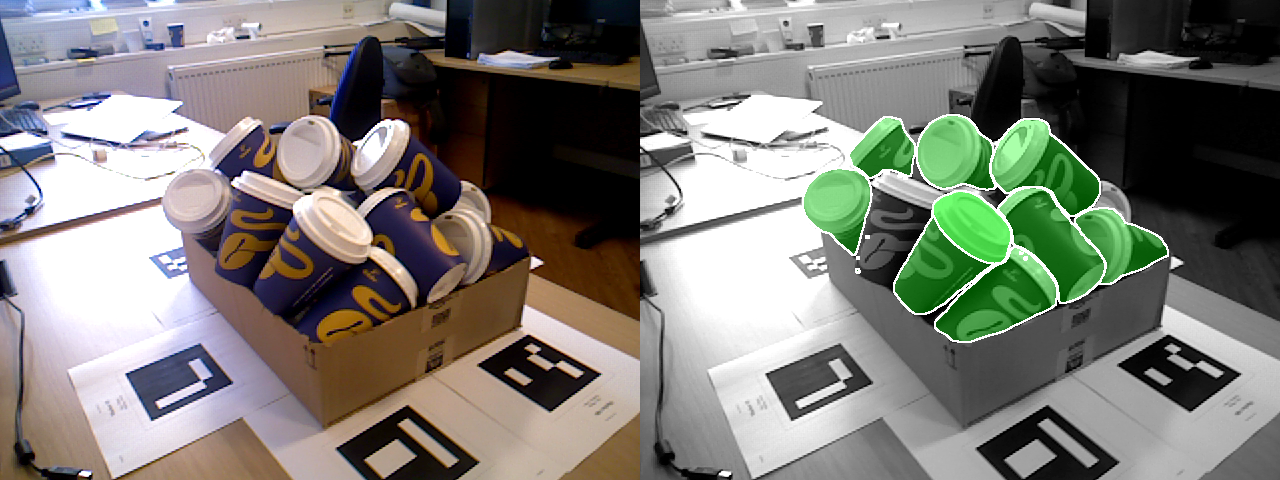

In [ ]:
# Real Templates
file_path = f"output_cnos_analysis_5/{real_data_type}"
custom_detections(sam_detections, proposals_features, real_ref_features, file_path = file_path, scene_id=1, frame_id=1)
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

File output_cnos_analysis_5/train_pbr.json has been deleted.
File output_cnos_analysis_5/train_pbr.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


Saved predictions to output_cnos_analysis_5/train_pbr.json


100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


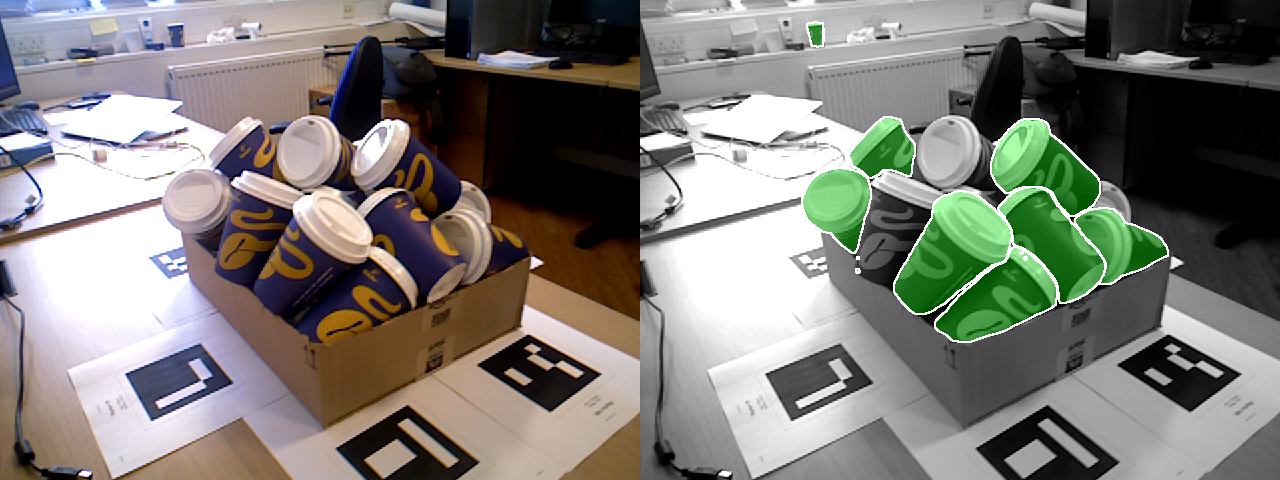

In [ ]:
# Synthetic Templates
file_path = f"output_cnos_analysis_5/{syn_data_type}"
custom_detections(sam_detections, proposals_features, syn_ref_features, file_path = file_path, scene_id=1, frame_id=1)
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

File output_cnos_analysis_5/pyrender.json has been deleted.
File output_cnos_analysis_5/pyrender.npz has been deleted.


Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


Saved predictions to output_cnos_analysis_5/pyrender.json


100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


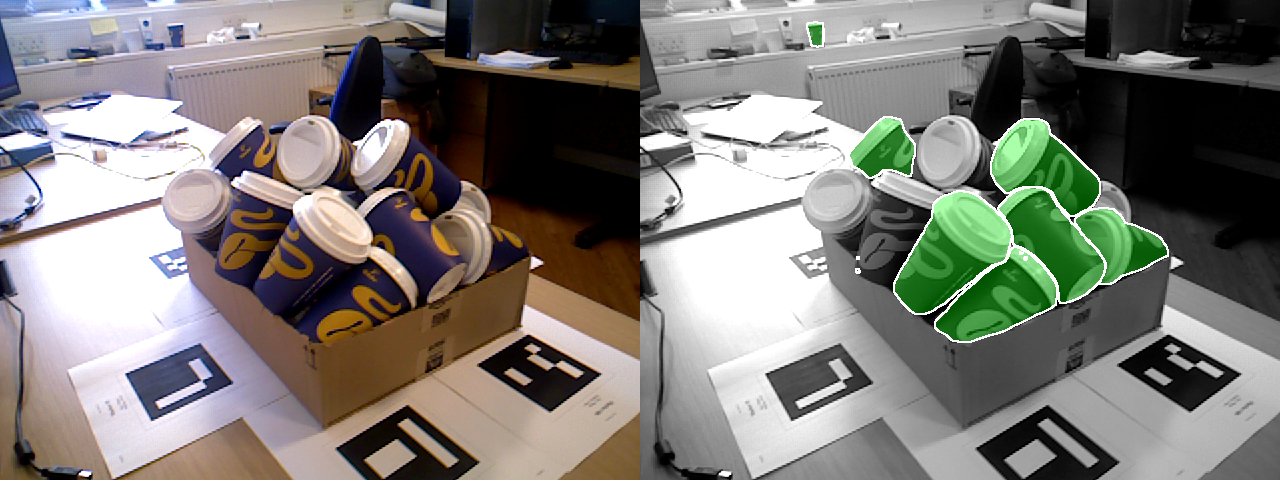

In [ ]:
# Pyrender Templates
file_path = f"output_cnos_analysis_5/pyrender"
custom_detections(sam_detections, proposals_features, pyrender_ref_features, file_path = file_path, scene_id=1, frame_id=1)
input_file = f"{file_path}.json"
final_result = custom_visualize(input_file, dataset_name, rgb_path)
final_result

In [ ]:
# from src.model.custom_cnos import modified_run_inference

# rgb_path = "cnos_analysis/crop_proposals/000001.png"
# template_dir = "foundpose_analysis/icbin/templates/test_images_templates/obj_000001_original"
# modified_run_inference(template_dir, rgb_path, sam_detections, real_ref_features, proposals_features)# , num_max_dets=15)

In [ ]:
# syn_template_dir = "foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original"
# modified_run_inference(syn_template_dir, rgb_path, sam_detections, syn_ref_features, proposals_features)

In [ ]:
# pyrender_template_dir = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001"
# modified_run_inference(pyrender_template_dir, rgb_path, sam_detections, pyrender_ref_features, proposals_features)

# 5. Experiments with FoundPose

## 5.1 Apply PCA for Top 3
Change the features extract to the modified code- then run the code below

In [ ]:
# from sklearn.decomposition import PCA
# concat_features = torch.cat(( normal_features.unsqueeze(0), real_ref_features[0]), dim=0) # [325, 900, 1024]
# # PCA
# pca = PCA(n_components=3, random_state=5)
# pca_patches_descriptors = [pca.fit_transform(np.array(concat_feature)).flatten() for concat_feature in concat_features]
# pca_normal_features = torch.tensor(pca_patches_descriptors[0])
# pca_real_ref_features = torch.tensor(pca_patches_descriptors[1:])
# calculate_similarity(crop_rgb, pca_normal_features.unsqueeze(0), pca_real_ref_features, real_templates)